In [ ]:
import re
import nltk

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import sys
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## 1. Генерирование русских имен при помощи RNN

Датасет: https://disk.yandex.ru/i/2yt18jHUgVEoIw

1.1 На основе файла name_rus.txt создайте датасет.
  * Учтите, что имена могут иметь различную длину
  * Добавьте 4 специальных токена:
    * `<PAD>` для дополнения последовательности до нужной длины;
    * `<UNK>` для корректной обработки ранее не встречавшихся токенов;
    * `<SOS>` для обозначения начала последовательности;
    * `<EOS>` для обозначения конца последовательности.
  * Преобразовывайте строку в последовательность индексов с учетом следующих замечаний:
    * в начало последовательности добавьте токен `<SOS>`;
    * в конец последовательности добавьте токен `<EOS>` и, при необходимости, несколько токенов `<PAD>`;
  * `Dataset.__get_item__` возращает две последовательности: последовательность для обучения и правильный ответ.
  
  Пример:
  ```
  s = 'The cat sat on the mat'
  # преобразуем в индексы
  s_idx = [2, 5, 1, 2, 8, 4, 7, 3, 0, 0]
  # получаем x и y (__getitem__)
  x = [2, 5, 1, 2, 8, 4, 7, 3, 0]
  y = [5, 1, 2, 8, 4, 7, 3, 0, 0]
  ```

1.2 Создайте и обучите модель для генерации фамилии.

  * Для преобразования последовательности индексов в последовательность векторов используйте `nn.Embedding`;
  * Используйте рекуррентные слои;
  * Задача ставится как предсказание следующего токена в каждом примере из пакета для каждого момента времени. Т.е. в данный момент времени по текущей подстроке предсказывает следующий символ для данной строки (задача классификации);
  * Примерная схема реализации метода `forward`:
  ```
    input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
    emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size]
    output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
    output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
  ```

1.3 Напишите функцию, которая генерирует фамилию при помощи обученной модели:
  * Построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * Начальное скрытое состояние RNN `h_t = None`;
  * В результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * Выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * Повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности.

При обучении каждые `k` эпох генерируйте несколько фамилий и выводите их на экран.

**1.1**

In [ ]:
class NamesDataset(Dataset):
    def __init__(self, file_path):
        self.vocab = self.build_vocab(file_path)
        self.data = self.process_data(file_path, self.vocab)

    def build_vocab(self, file_path):
        with open(file_path, 'r', encoding='cp1251') as file:
            names = [line.strip() for line in file]

        all_chars = set(''.join(names))
        all_chars.update(['<PAD>', '<UNK>', '<SOS>', '<EOS>'])

        char_to_idx = {char: idx for idx, char in enumerate(all_chars)}

        return char_to_idx

    def process_data(self, file_path, vocab):
        data = []
        with open(file_path, 'r', encoding='cp1251') as file:
            names = [line.strip() for line in file]

        for name in names:
            sequence = [vocab['<SOS>']] + [vocab[char] if char in vocab else vocab['<UNK>'] for char in name] + [vocab['<EOS>']]
            data.append(sequence)

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sequence = self.data[index]

        x = torch.tensor(sequence[:-1])
        y = torch.tensor(sequence[1:])

        return x, y

**Пример использования класса:**

In [ ]:
file_path = '/content/drive/MyDrive/name_rus.txt'
dataset = NamesDataset(file_path)

example_idx = 0
x, y = dataset[example_idx]
print("Пример x:", x)
print("Пример y:", y)

Пример x: tensor([13, 21, 12, 17, 16,  2, 18,  3])
Пример y: tensor([21, 12, 17, 16,  2, 18,  3, 14])


**1.2**

In [ ]:
class NameGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(NameGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.rnn(x, hidden)
        output = output.reshape(-1, output.size(2))
        output = self.linear(output)
        return output

In [ ]:
vocab_size = len(dataset.vocab)
embedding_size = 50
hidden_size = 100

model = NameGenerator(vocab_size, embedding_size, hidden_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=lambda x: (pad_sequence([item[0] for item in x], batch_first=True, padding_value=0), pad_sequence([item[1] for item in x], batch_first=True, padding_value=0)))

test_batch_size = 64
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, collate_fn=lambda x: (pad_sequence([item[0] for item in x], batch_first=True, padding_value=0), pad_sequence([item[1] for item in x], batch_first=True, padding_value=0)))

In [ ]:
train_losses = []
test_losses = []
num_epochs = 30

In [ ]:
for epoch in range(num_epochs):

    model.train()
    train_epoch_loss = 0.0

    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y.view(-1))
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()

    average_train_loss = train_epoch_loss / len(train_dataloader)
    train_losses.append(average_train_loss)


    model.eval()
    test_epoch_loss = 0.0

    with torch.no_grad():
        for batch_x, batch_y in test_dataloader:
            output = model(batch_x)
            loss = criterion(output, batch_y.view(-1))
            test_epoch_loss += loss.item()

    average_test_loss = test_epoch_loss / len(test_dataloader)
    test_losses.append(average_test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {average_train_loss}, Test Loss: {average_test_loss}')

Epoch 1/30, Train Loss: 2.4273111057281493, Test Loss: 1.8749008178710938
Epoch 2/30, Train Loss: 1.711406011581421, Test Loss: 1.5547673531941004
Epoch 3/30, Train Loss: 1.452630181312561, Test Loss: 1.400106736591884
Epoch 4/30, Train Loss: 1.3576718473434448, Test Loss: 1.3144124405724662
Epoch 5/30, Train Loss: 1.2800198316574096, Test Loss: 1.259340524673462
Epoch 6/30, Train Loss: 1.2197627639770507, Test Loss: 1.221017633165632
Epoch 7/30, Train Loss: 1.179951663017273, Test Loss: 1.1946122986929757
Epoch 8/30, Train Loss: 1.179359622001648, Test Loss: 1.1722187740462167
Epoch 9/30, Train Loss: 1.1415320801734925, Test Loss: 1.1523654801504952
Epoch 10/30, Train Loss: 1.1339564394950867, Test Loss: 1.1379890441894531
Epoch 11/30, Train Loss: 1.1227835845947265, Test Loss: 1.1240408079964774
Epoch 12/30, Train Loss: 1.0927919793128966, Test Loss: 1.1106848801885332
Epoch 13/30, Train Loss: 1.0881767344474793, Test Loss: 1.0986888238361903
Epoch 14/30, Train Loss: 1.07884482622146

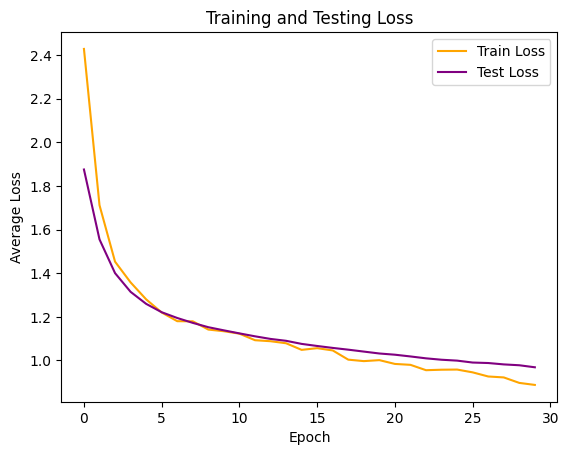

In [ ]:
plt.plot(train_losses, label='Train Loss', color='orange')
plt.plot(test_losses, label='Test Loss', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'name_generator_model.pth')

**1.3**

In [ ]:
def generate_surname(model, vocab, max_length=20, sos_token='<SOS>', eos_token='<EOS>'):
    device = next(model.parameters()).device
    sequence = [vocab[sos_token]]
    hidden = None

    for _ in range(max_length):
        input_tensor = torch.tensor(sequence, dtype=torch.long, device=device).view(1, -1)

        # Пропуск последнего токена через модель
        if hidden is not None:
            output, hidden = model(input_tensor, hidden)
        else:
            output = model(input_tensor)
            hidden = None

        # Применение softmax для получения вероятностного распределения
        probabilities = torch.softmax(output[-1], dim=0)

        next_token = torch.multinomial(probabilities, 1).item()
        sequence.append(next_token) # последовательность

        if next_token == vocab[eos_token]:
            break

    # Исключаем токены SOS и EOS из генерированной фамилии
    generated_surname = ''.join([token for token, idx in vocab.items() if idx in sequence[1:-1]])

    return generated_surname

In [ ]:
model.eval()

for _ in range(5):
    generated_surname = generate_surname(model, dataset.vocab)
    print("Generated Surname:", generated_surname)

Generated Surname: кьланм
Generated Surname: кслеамг
Generated Surname: хеуанг
Generated Surname: иксьчнм
Generated Surname: икыслдечан


## 2. Генерирование текста при помощи RNN

2.1 Скачайте из интернета какое-нибудь художественное произведение
  * Выбирайте достаточно крупное произведение, чтобы модель лучше обучалась;

2.2 На основе выбранного произведения создайте датасет.

Отличия от задачи 1:
  * Токены <SOS>, `<EOS>` и `<UNK>` можно не добавлять;
  * При создании датасета текст необходимо предварительно разбить на части. Выберите желаемую длину последовательности `seq_len` и разбейте текст на построки длины `seq_len` (можно без перекрытия, можно с небольшим перекрытием).

2.3 Создайте и обучите модель для генерации текста
  * Задача ставится точно так же как в 1.2;
  * При необходимости можете применить:
    * двухуровневые рекуррентные слои (`num_layers`=2)
    * [обрезку градиентов](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)

2.4 Напишите функцию, которая генерирует фрагмент текста при помощи обученной модели
  * Процесс генерации начинается с небольшого фрагмента текста `prime`, выбранного вами (1-2 слова)
  * Сначала вы пропускаете через модель токены из `prime` и генерируете на их основе скрытое состояние рекуррентного слоя `h_t`;
  * После этого вы генерируете строку нужной длины аналогично 1.3


**2.1**

In [ ]:
with open('/content/drive/MyDrive/The-Great-Gatsby.txt') as file:
    text = file.read()
    text = text.replace('\n', ' ').lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
print(text[:1000])

chapter i in my younger and more vulnerable years my father gave me some advice that i ve been turning over in my mind ever since whenever you feel like criticizing any one he told me just remember that all the people in this world haven t had the advantages that you ve had he didn t say any more but we ve always been unusually communicative in a reserved way and i understood that he meant a great deal more than that in consequence i m inclined to reserve all judgments a habit that has opened up many curious natures to me and also made me the victim of not a few veteran bores the abnormal mind is quick to detect and attach itself to this quality when it appears in a normal person and so it came about that in college i was unjustly accused of being a politician because i was privy to the secret grief s of wild unknown men most of the confidences were unsought frequently i have feigned sleep preoccupation or a hostile levity when i realized by some unmistakable sign that an intimate reve

In [ ]:
text = text.split()

In [ ]:
seq_len = 100
step_size = 1

In [ ]:
def create_dataset(text, seq_len, step_size):
    sequences = []
    for i in range(0, len(text) - seq_len + 1, step_size):
        seq = text[i : i + seq_len]
        sequences.append(seq)

    df = pd.DataFrame({'sequences': sequences})
    return df

In [ ]:
df_sequences = create_dataset(text, seq_len, step_size)

In [ ]:
class Vocab:
    def __init__(self, data):
        self.idx_to_token, self.token_to_idx = self.build_vocab(data)
        self.vocab_len = len(self.idx_to_token)
        self.max_seq_len = self.calculate_max_seq_len(data)

        self.pad_idx = self.token_to_idx['<PAD>']
        self.sos_idx = self.token_to_idx['<SOS>']

    def calculate_max_seq_len(self, data):
        return max(len(seq) for seq in data)

    def build_vocab(self, data):
        tokens = list(['<PAD>', '<SOS>'])

        for seq in data:
          for token in seq:
            if token not in tokens:
              tokens.append(token)

        idx_to_token = {idx: token for idx, token in enumerate(tokens, start=0)}
        token_to_idx = {token: idx for idx, token in enumerate(tokens, start=0)}

        return idx_to_token, token_to_idx

    def to_tokens(self, ids):
        ids_sub = []
        for idx in ids:
            if self.idx_to_token[int(idx)] not in ['<PAD>', '<UNK>', '<SOS>', '<EOS>']:
                ids_sub.append(self.idx_to_token[int(idx)])

        return ' '.join(ids_sub)

    def lookup_tokens(self, idx):
        token = self.idx_to_token[int(idx)]
        return token

    def lookup_indices(self, tokens):
        index = []
        for token in tokens:
          index.append(self.token_to_idx[token])
        return index

    def to_ids(self, tokens):
        tokens = [self.token_to_idx[token] for token in tokens]
        pad_count = self.max_seq_len - len(tokens)
        tokens = tokens + [self.pad_idx] * pad_count
        tokens = [self.sos_idx] + tokens
        return tokens

In [ ]:
vocab = Vocab(df_sequences['sequences'])
vocab.vocab_len

5822

In [ ]:
class G_Dataset(Dataset):
    def __init__(self, data, vocab):
        self.data = data
        self.vocab = vocab

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        _x = self.vocab.to_ids(self.data.iloc[idx])
        return torch.tensor(_x[:-1]), torch.tensor(_x[1:])

In [ ]:
dataset = G_Dataset(df_sequences['sequences'], vocab)
x, y = next(iter(dataset))

In [ ]:
class G_Net(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, num_layers):
        super(G_Net, self).__init__()

        self.vocab = vocab

        self.embedding = nn.Embedding(num_embeddings=self.vocab.vocab_len, embedding_dim=embedding_size)
        self.rnn = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(in_features=hidden_size, out_features=self.vocab.vocab_len)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        output = output.reshape(-1, output.size(2))
        output = self.fc1(output)
        return output, hidden

    def generate(self, prime, max_len=100):
        tokens = prime.split(' ')
        prime_idxs = [self.vocab.sos_idx] + self.vocab.lookup_indices(tokens)
        last_prime_idx = prime_idxs[-1]
        prime_idxs = torch.tensor([prime_idxs]).to(device)
        output, hidden = self(prime_idxs)
        current_token = torch.tensor([[last_prime_idx]]).to(device)

        for _ in range(max_len - len(prime)):
            output, hidden = self.forward(current_token, hidden)
            output = output.squeeze()
            probabilities = torch.softmax(output, dim=0)
            next_token = torch.multinomial(probabilities, num_samples=1)
            next_token = next_token.item()

            if next_token not in (self.vocab.pad_idx,
                                  self.vocab.sos_idx):
                tokens.append(self.vocab.lookup_tokens(next_token))

            current_token = torch.tensor([[next_token]]).to(device)

        return ' '.join(tokens)

In [ ]:
batch_size = 256
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_embeddings = vocab.vocab_len
embedding_size = 110
hidden_size = 130
num_layers = 2

model = G_Net(vocab, embedding_size, hidden_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, vocab, k=5):
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for batch_num, (batch_x, batch_y) in enumerate(train_loader, 1):
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs, _ = model(batch_x)
            loss = criterion(outputs, batch_y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()


        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)

        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
        text = model.generate('i in my younger', max_len=50)
        print(f'Generated_text: {text}')

    plt.plot(losses, label='Train Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.title('Training and Testing Loss')
    plt.show()

Epoch: 1/10, Loss: 0.7643
Generated_text: i in my younger and splashed to its own gayety and as we shook hands with abruptly but i didn t want to have it jimmy was a truck hurried up at all and i could make something of
Epoch: 2/10, Loss: 0.6782
Generated_text: i in my younger and the dancing began i d been now she was below me everybody kept saying to me lucille that man s suggestion a great old thing you didn t see a story you never like
Epoch: 3/10, Loss: 0.6047
Generated_text: i in my younger and voices slowly and dance it s the policeman she told me i was stupid with june innumerable single excellence and wild servants made familiar the national people wilson klipspringer there he had already a
Epoch: 4/10, Loss: 0.5431
Generated_text: i in my younger and voices slowly and cool table i was poor of the house that except for a solitary restaurant was soft road looks empty can suit such city that coupe and mine the secret ones made
Epoch: 5/10, Loss: 0.4918
Generated_text: i in my yo

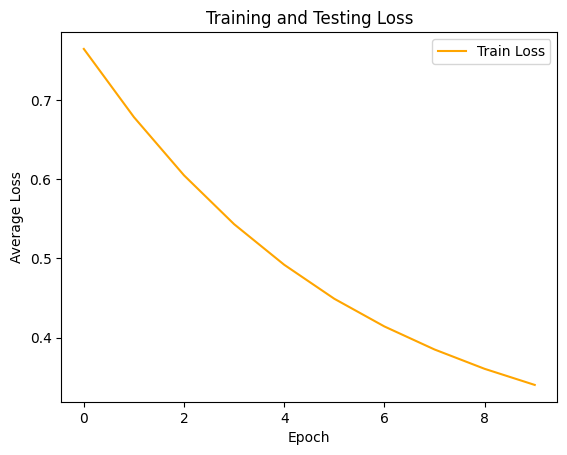

In [ ]:
num_epochs = 10
train_model(model, train_loader, criterion, optimizer, num_epochs, vocab, k=5)